# Agglomerative and kMeans Clustering on wine dataset 
## using Dimensionality Reduction techniques 

---
# 1. Data Preprocessing & EDA

---
## Loading the libraries

In [1]:
import random
import numpy as np
import pandas as pd
import tqdm       
import copy
import itertools 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import ParameterGrid

# Unsupervised Learning models / Clustering
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Unsupervised Learning models / Clustering metrics
from sklearn.metrics import silhouette_score
from sklearn import metrics

RANDOM_STATE=42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

import warnings
warnings.filterwarnings('ignore')

from summarytools import dfSummary

---
## Read the Dataset

In [2]:
org_df = pd.read_csv('wine-clustering.csv')
df = org_df.copy()

display(df.head())

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


---
## Preliminary analysis of a dataset

In [3]:
# I came across this cool function and I decided to try it :-)

dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Alcohol[float64],Mean (sd) : 13.0 (0.8)min < med < max:11.0 < 13.1 < 14.8IQR (CV) : 1.3 (16.0),126 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy88F64QAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAC50lEQVR4nO3dMY7aQBSA4TewIBuQEUILHU3KSBSUHCKHzRFScAKKNFR0FggZ4SzBGNIkEYlYWHvsZZ73/+od1sUvNPaMB3M+nwVwXe3RFwC8xdOjL6AsxhhfRJoWH3E4n88vRV0P7FQyVGOM3+/3vwRB0Mv7GdvtdmOM+UqsbqhkqCLSDIKgN51OX7rd7j7r4CiKvNls1luv100RIVQHVDVUERHpdrv7wWDwI+dwv9CLgRVupqACoUIFQoUKhAoVCBUqVPqu/1EsFxtYaLiCUAtmu9jAQsN1hFq83IsNLDS8jlBLYrHYwELDFYTqmDRNGyISGGPyfkRNRE45xzo7PyZUh8Rx3EiSZDwajer1ej3zHoU0TRtxHH/qdDqLWq2WZB3v8vyYUB1yOByePM9rTSaT/XA43GQdv1wue/P5/HkymXzPOt71+TGhOqjdbuea3242G99mvDg8P+aBP1QgVKhAqFCBUKECoUIF7vpfYfHgPTidTo0SLulDI9QrbB68J0nipWn6eb/ffxORvO9r4T+EeoXNg/ffD91bx+OxXtb1fUSEekOeB+d/HrqjWE6HarEBmXlixTgbqs0GZOaJ1eNsqGKxAZl5YvW4HKqI5NuAzDyxepwPFe+ngE3bpW28JlSIiP2mbZFyN14TKkTEftN22RuvCRX/sNh0LVLixms2pUAFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFUpd67c8y57XSfBXaaHanmXP6yS4VOY3qtUP5/I6CS6Vvs0v71n2vE6CS9xMQQVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSowGl+KIzlQcA3DwEmVBTC9iDge4cA3w2Vn9DBW9gcBPyWQ4BvhspP6CAri4OAb77Rce8btRkEQW88Hovv+z+z/NfVauUtFotWFEXtMAwPWcaKiOx2O09EJI5jLwzD1nuNfeT/1nrdtuOjKPLu/c0vSzub4QQdk+EAAAAASUVORK5CYII="">",0(0.0%)
2,Malic_Acid[float64],Mean (sd) : 2.3 (1.1)min < med < max:0.7 < 1.9 < 5.8IQR (CV) : 1.5 (2.1),133 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy88F64QAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACvUlEQVR4nO3du47aQBSA4TOwIHORESKBjiZlpBQueYg8bB4hSPsEFGlS0SEhBMJZC2OcItk00XKZseM5k//rB7v4xTLembEpy1IA37WavgHgHk91frgxpiciXYePOJVl+VLV/UCv2kI1xvQmk8nnOI7Htp9xOBx2xpgvxIo6v1G7cRyPF4vFy2g0yh4dvN/vo+fn5/F2u+2KCKH+52r90y8iMhqNsul0+sNyeK/Sm4FaTKagAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFChdqP9HFRFEVHRGJjjM1wTgIMiLehpmnayfP803w+b7fb7YcPWeMkwLB4G+rpdHqKoqifJEk2m812j4zlJMDweBvqq8FgYHsaICcBBoTJFFQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFChZurpxxeZR5fLpeOxTjgL1dDdXmVeZ7nUVEUH7Ms+yoiti/tBUTk9jeq9avM1+v1eLVa9c/nc9vh/qw5bmMRYSuLV+5aOG3zKvPdbtfYwmXXbSwibGXxjfcr/G24bGMR+bWVZblcTrfb7TtjzMHmFmwDd5gTOF/bZ0GG+sp2G0tTGwtd5gSu1/Zd0KHaanBjofWcoIJre41Qr2hqY6HNnKCqa/uKUGvg8MSBZ89vINSKufy+5dnz2wi1Yi6/b5t+9uwzQq2Jze/bJp89+45QAxPqwXKEGpCQD5Yj1ICEfLAcoQYoxIPlWDgNFfhGxR8VLI1sicjFcuzViRyhQkTcJ2JFUXTSNP0wHA6/t1qt/NHxtyZyhAoRcV8a+fufFe+TJPlWx0TurlD3+330yIVFRI7HYyQikqZptNls+v9yvNZr+3DfvvoJDY6h6gZFkN4AAAAASUVORK5CYII="">",0(0.0%)
3,Ash[float64],Mean (sd) : 2.4 (0.3)min < med < max:1.4 < 2.4 < 3.2IQR (CV) : 0.3 (8.6),79 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy88F64QAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACrUlEQVR4nO3dvY7aQBRA4TthIQYiG0QEHS1FpBSUPEQeNo+QlShSIt6ADmEsEA4OxpAiWolIhA3+CXNnz9fP7hRHSIMvY3M+nwWw3btHbwD4F0+P3oCLjDFNEWnkXH44n8/7MvfjAkItmTGm2ev1vvi+382zfrvdRsaYr8T6J0ItX8P3/e5kMtkHQZDcs3Cz2XjT6bQbhmFDRAj1AqFWJAiCpN/v/8ixtFn6ZhzAYQoqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVOAR6l8UmIDyT6dTvez9vHWEekWRCag0Tb0syz4lSfJNRPI868cVhHpd7gmoxWLRnc/nrePxWKtqc28Rod6QZwIqiiKmnyrAYQoqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqMCzfstkWVYXEd8Yk/dPOHnJGqFaJI7jepqmn4fDYa1Wq901tfXC1UvWCNUih8PhyfO81ng8TgaDQXTvepcvWSNUC7Xb7bwXrIk4eskahymoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqMCTKccUHGqxdqCFUB1SdKjF5oEWQnVIkaEW2wdaCNVBBYZarB1o4TAFFQgVKhAqVCBUqODsYarAHfwi3MNvHSdDLXIHvwj38NvIyVClwB38ItzDbyNXQxWRfHfwi3APv404TEEFQoUKhAoVCBUqWH2Y4n2keGFtqLyPFJesDVV4Hyku2ByqiPA+UvzGYQoqVPqJymCILjbfdl1ZqAyG6GL7bddVfqIyGKJIGbddPz8/98Mw/GiM2ebZwq3AXw216HeZQRBEDIbokfeHgVX/VPtmqGV8l7larb7fu1ZEZLfbeSIicRx7y+Wy9b/WPvJ/a923iMh6vf7geV5rNBqZTqfz8561+/3+/Ww2u/lT7V/1d4QF1qYz3QAAAABJRU5ErkJggg=="">",0(0.0%)
4,Ash_Alcanity[fl

In [4]:
print('Shape of the dataset:\n-------------------------------------------------------------')
print(f'{df.shape[0]} x {df.shape[1]}\n\n')

print('Basic info of the dataset:\n-------------------------------------------------------------')
print(df.info(), '\n\n')

print('Sum of NaN values in each column:\n-------------------------------------------------------------')
print(df.isna().sum(), '\n\n')

Shape of the dataset:
-------------------------------------------------------------
178 x 13


Basic info of the dataset:
-------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float

In [5]:
print('Duplicates in the dataset:\n-------------------------------------------------------------')
display(df.loc[df.duplicated()])

print('\n\n\nUnique data in the dataset:\n-------------------------------------------------------------')
print(df.nunique().sort_values())

Duplicates in the dataset:
-------------------------------------------------------------


,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline





Unique data in the dataset:
-------------------------------------------------------------
Nonflavanoid_Phenols     39
Magnesium                53
Ash_Alcanity             63
Hue                      78
Ash                      79
Total_Phenols            97
Proanthocyanins         101
Proline                 121
OD280                   122
Alcohol                 126
Flavanoids              132
Color_Intensity         132
Malic_Acid              133
dtype: int64


In [6]:
# Summary Statistics of the dataset

df.describe()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


---
# CONCLUSION from preliminary analysis of a dataset:
---
### Shape of a Dataset:     
Shape of the dataset is: 178 rows x 13 columns.

### NaN values:  
There are no NaN values in the dataset.

### Constant values:  
There are no features with one constant value in the dataset.

### Data types:  
All of the features have appropriate data type.

### Duplicates:  
There are no duplicate rows in the dataset.

### Typos:       
There are no typos that need to be corrected.

### Descriptive statistics:
The summary statistics for the numerical columns in the dataset shows quick overview of the distribution and data variability that occurs in all columns. Nothing specific can be seen so far. 

---
# Exploratory Data Analysis

## Correlation between columns

<Axes: >

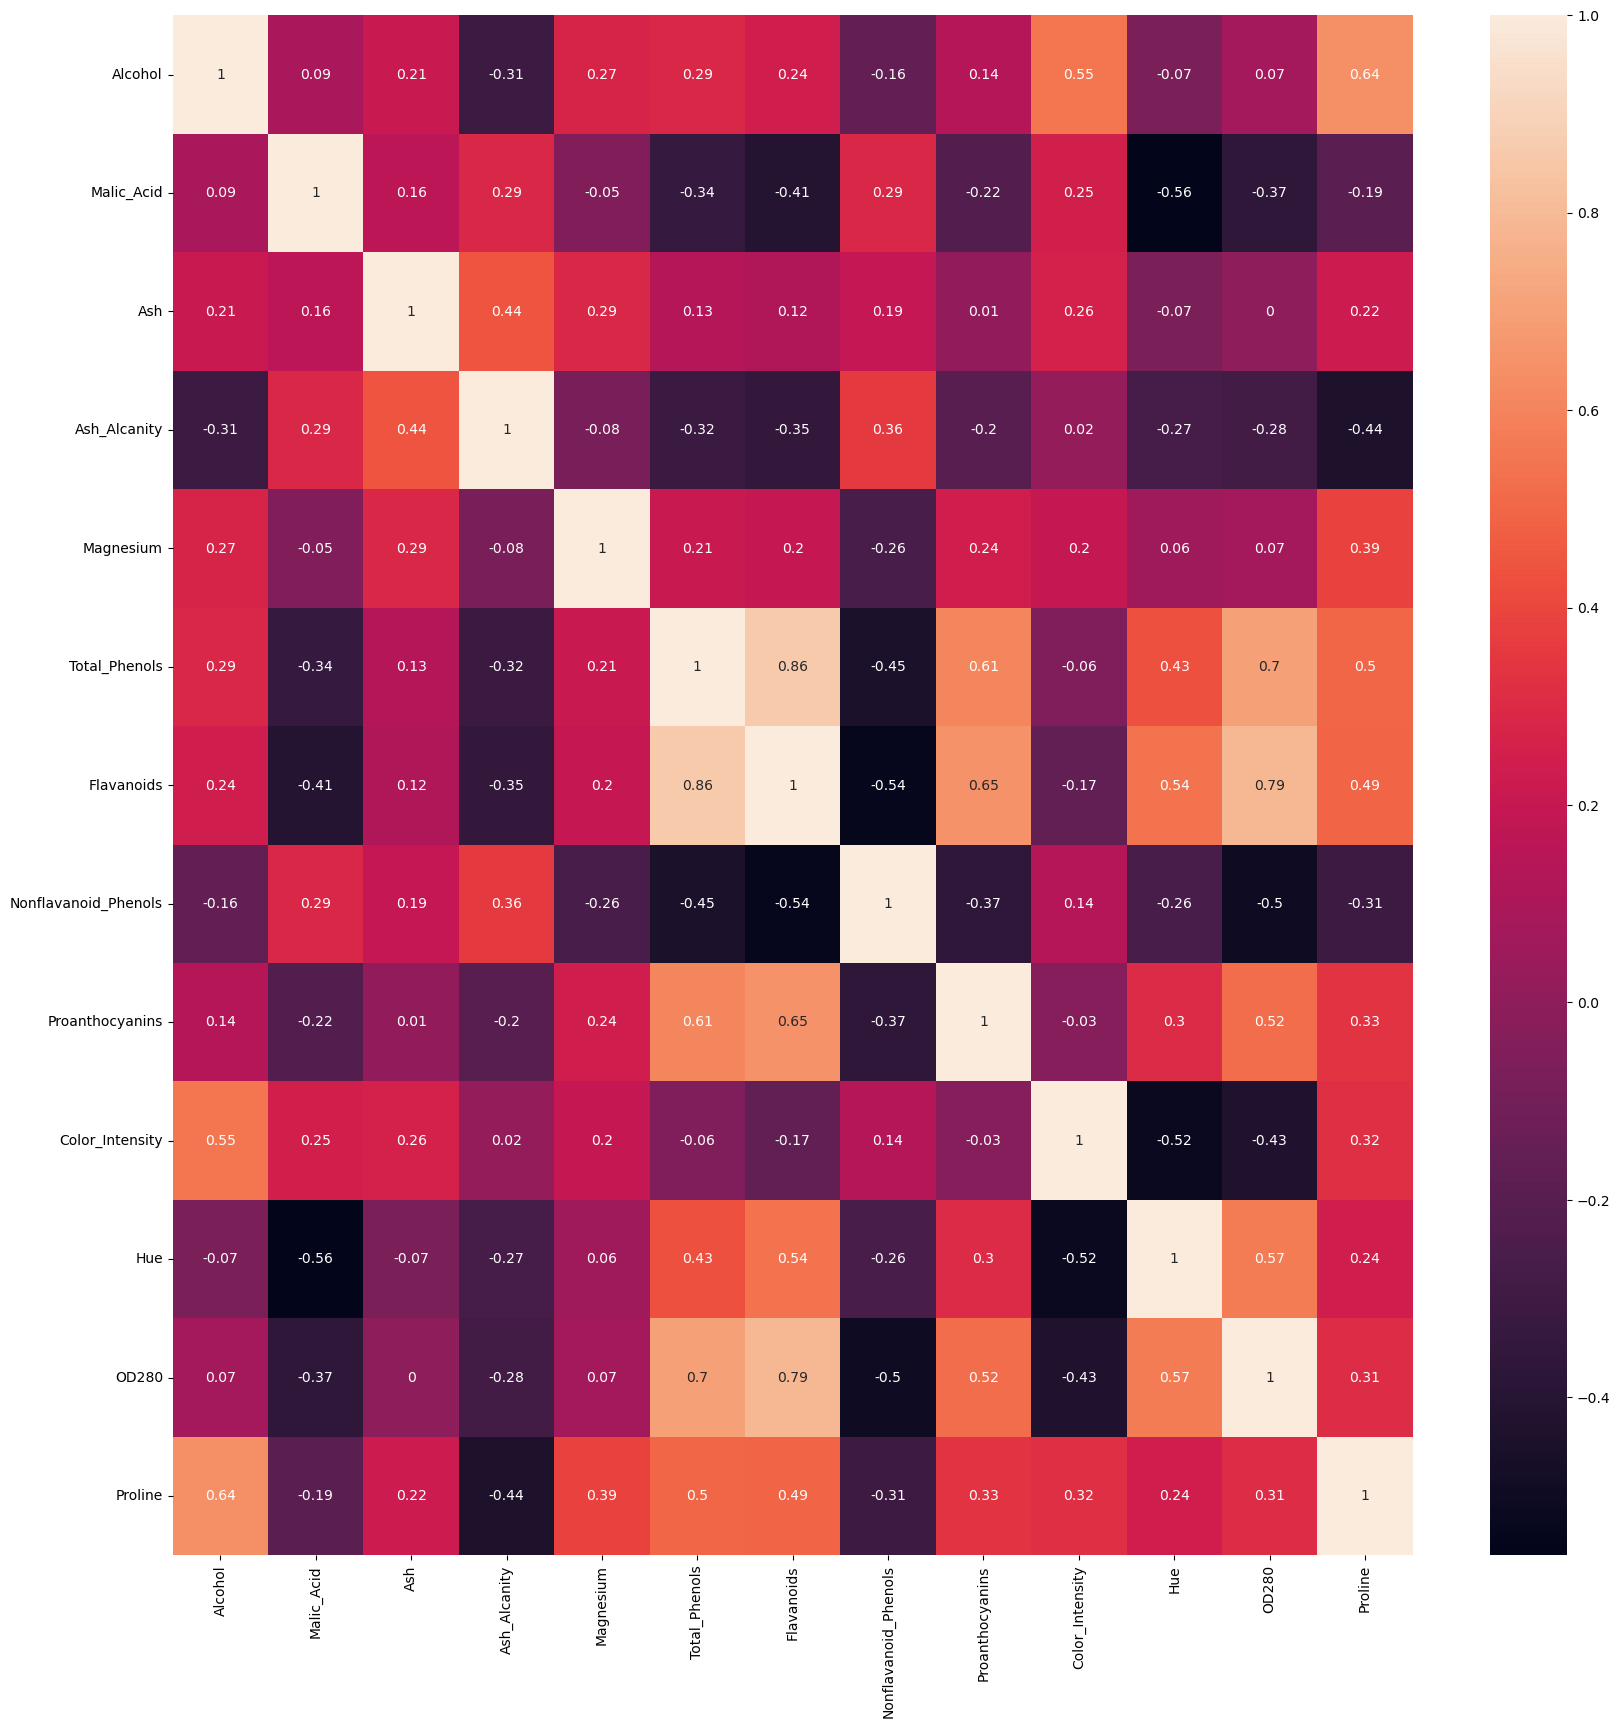

In [7]:
df_corr = df.corr(numeric_only=True, method='pearson').round(decimals=2)
plt.figure(figsize=(20,20))
sns.heatmap(df_corr, annot=True) 

## Visual representation of the Dataset

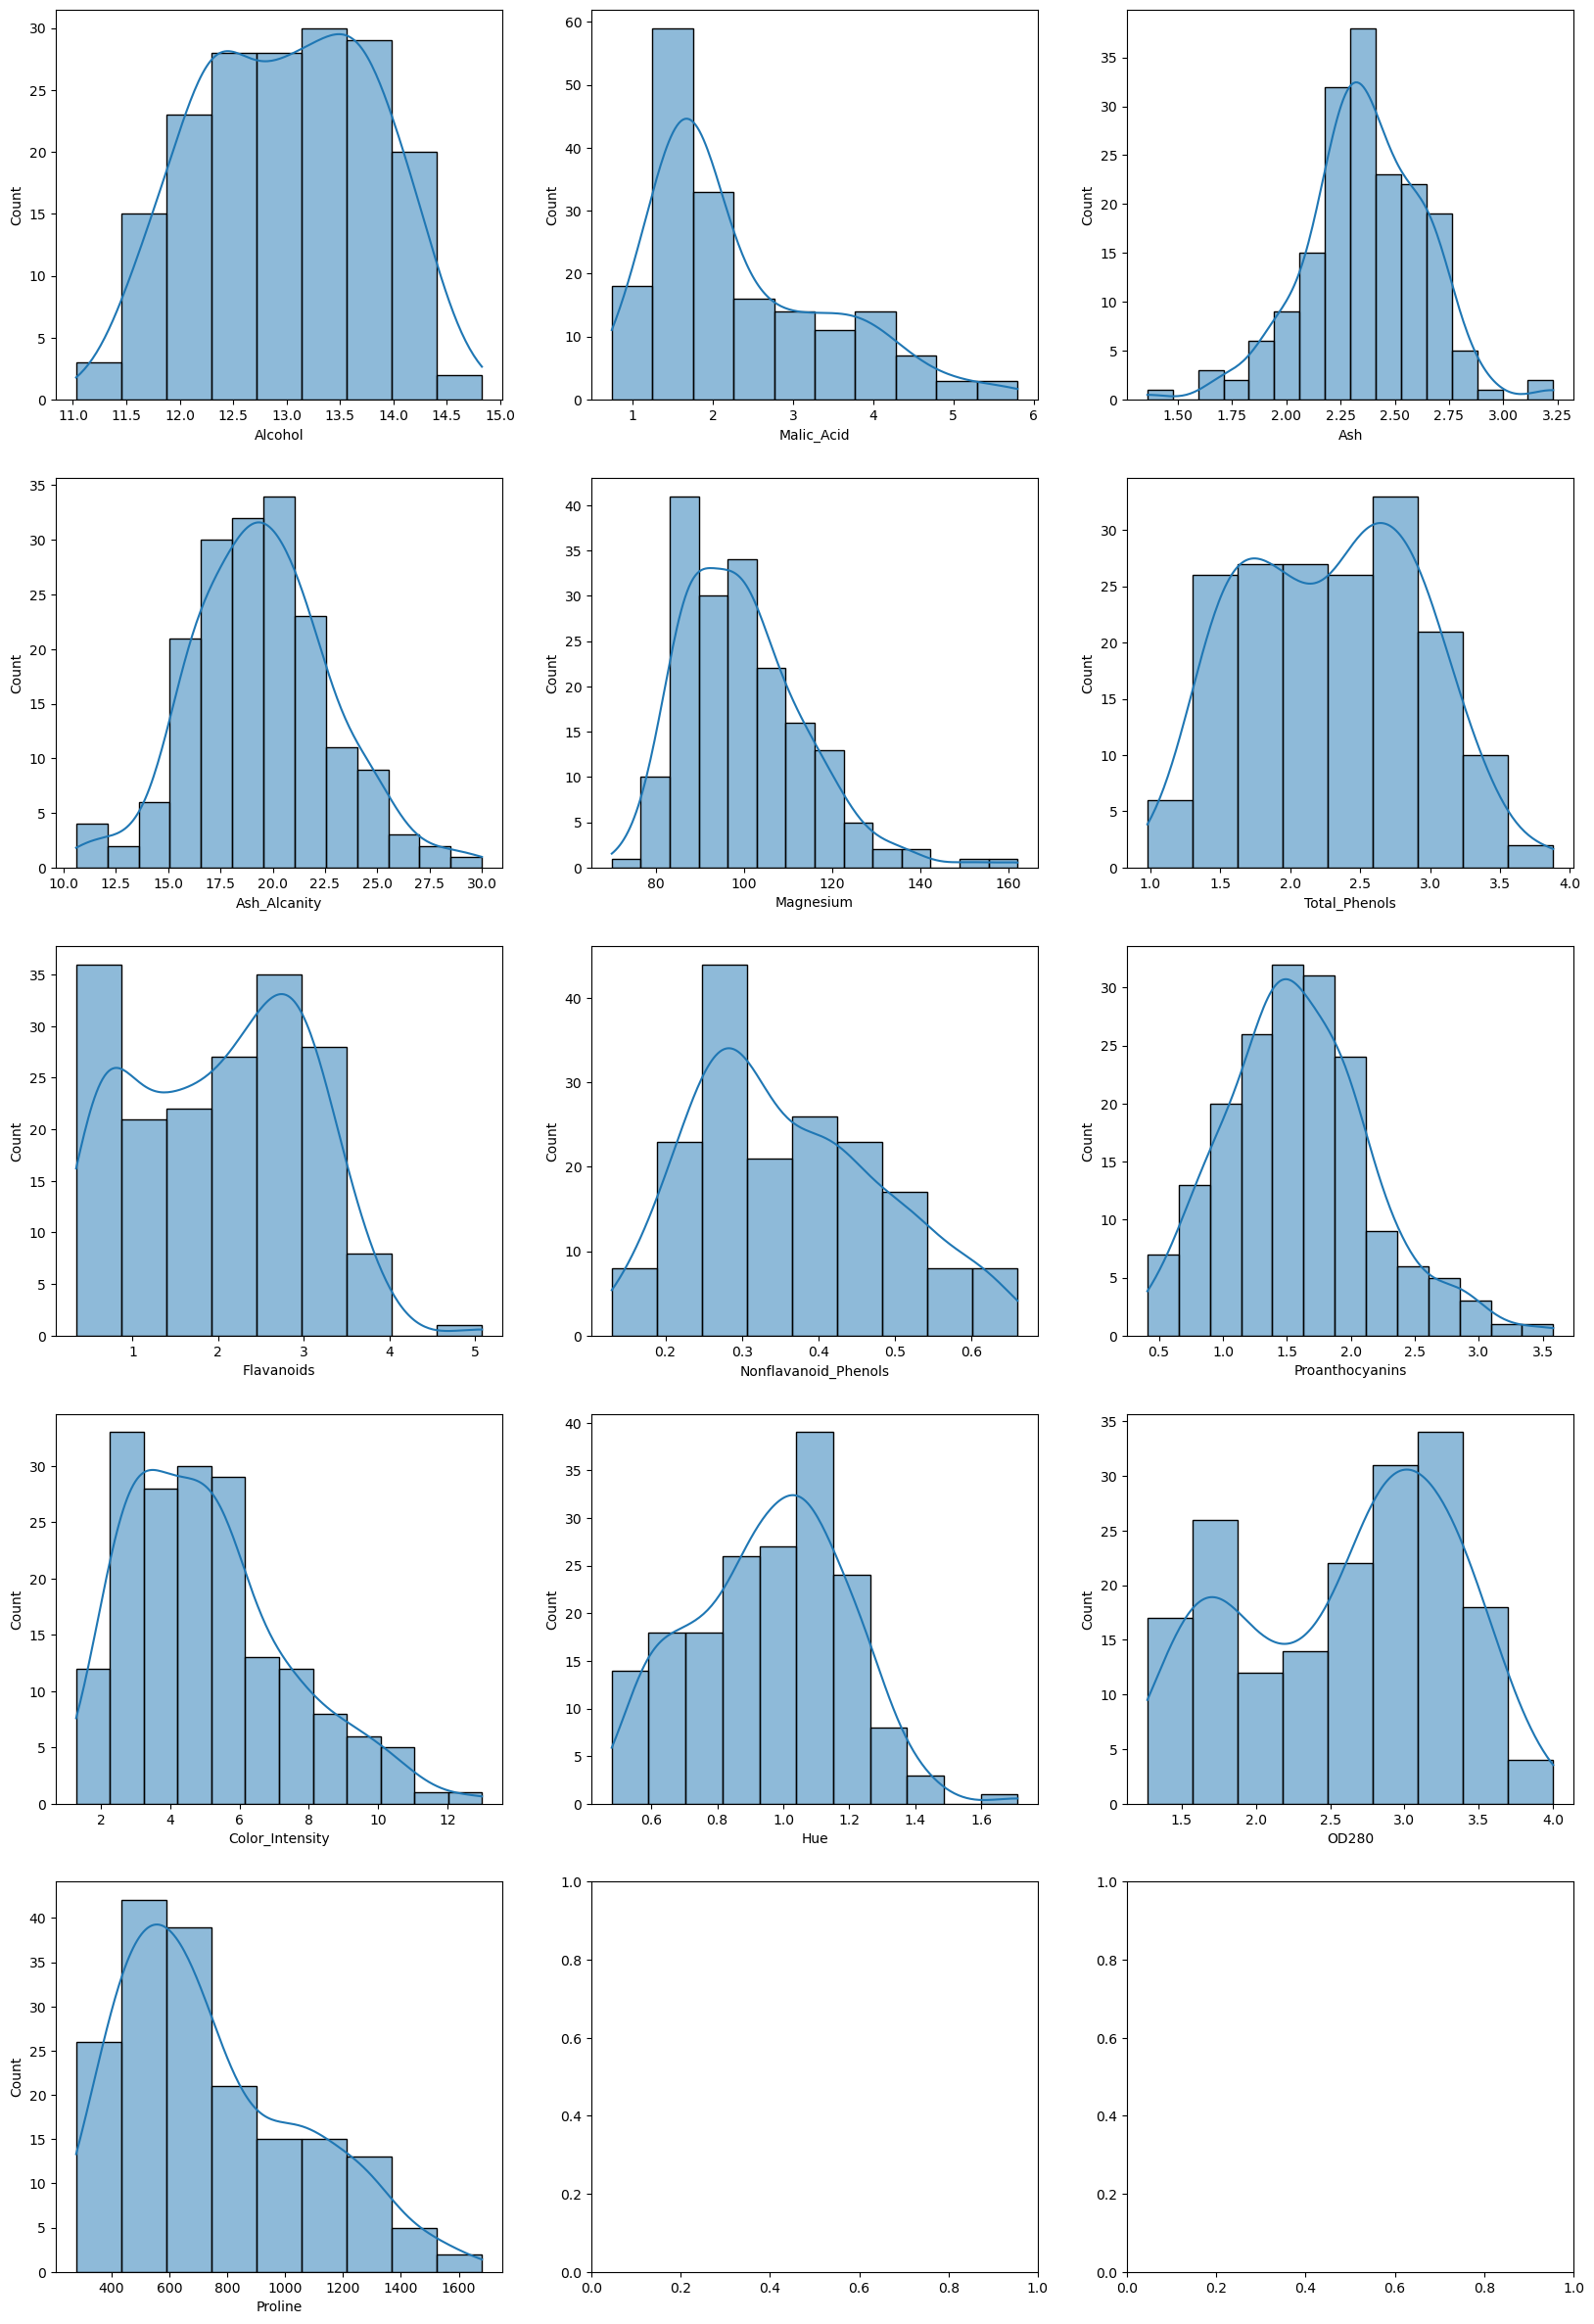

In [8]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(20,30))
axs = axs.ravel()

for i, c in enumerate(df):
    sns.histplot(df, x=df[c], ax=axs[i], kde=True)

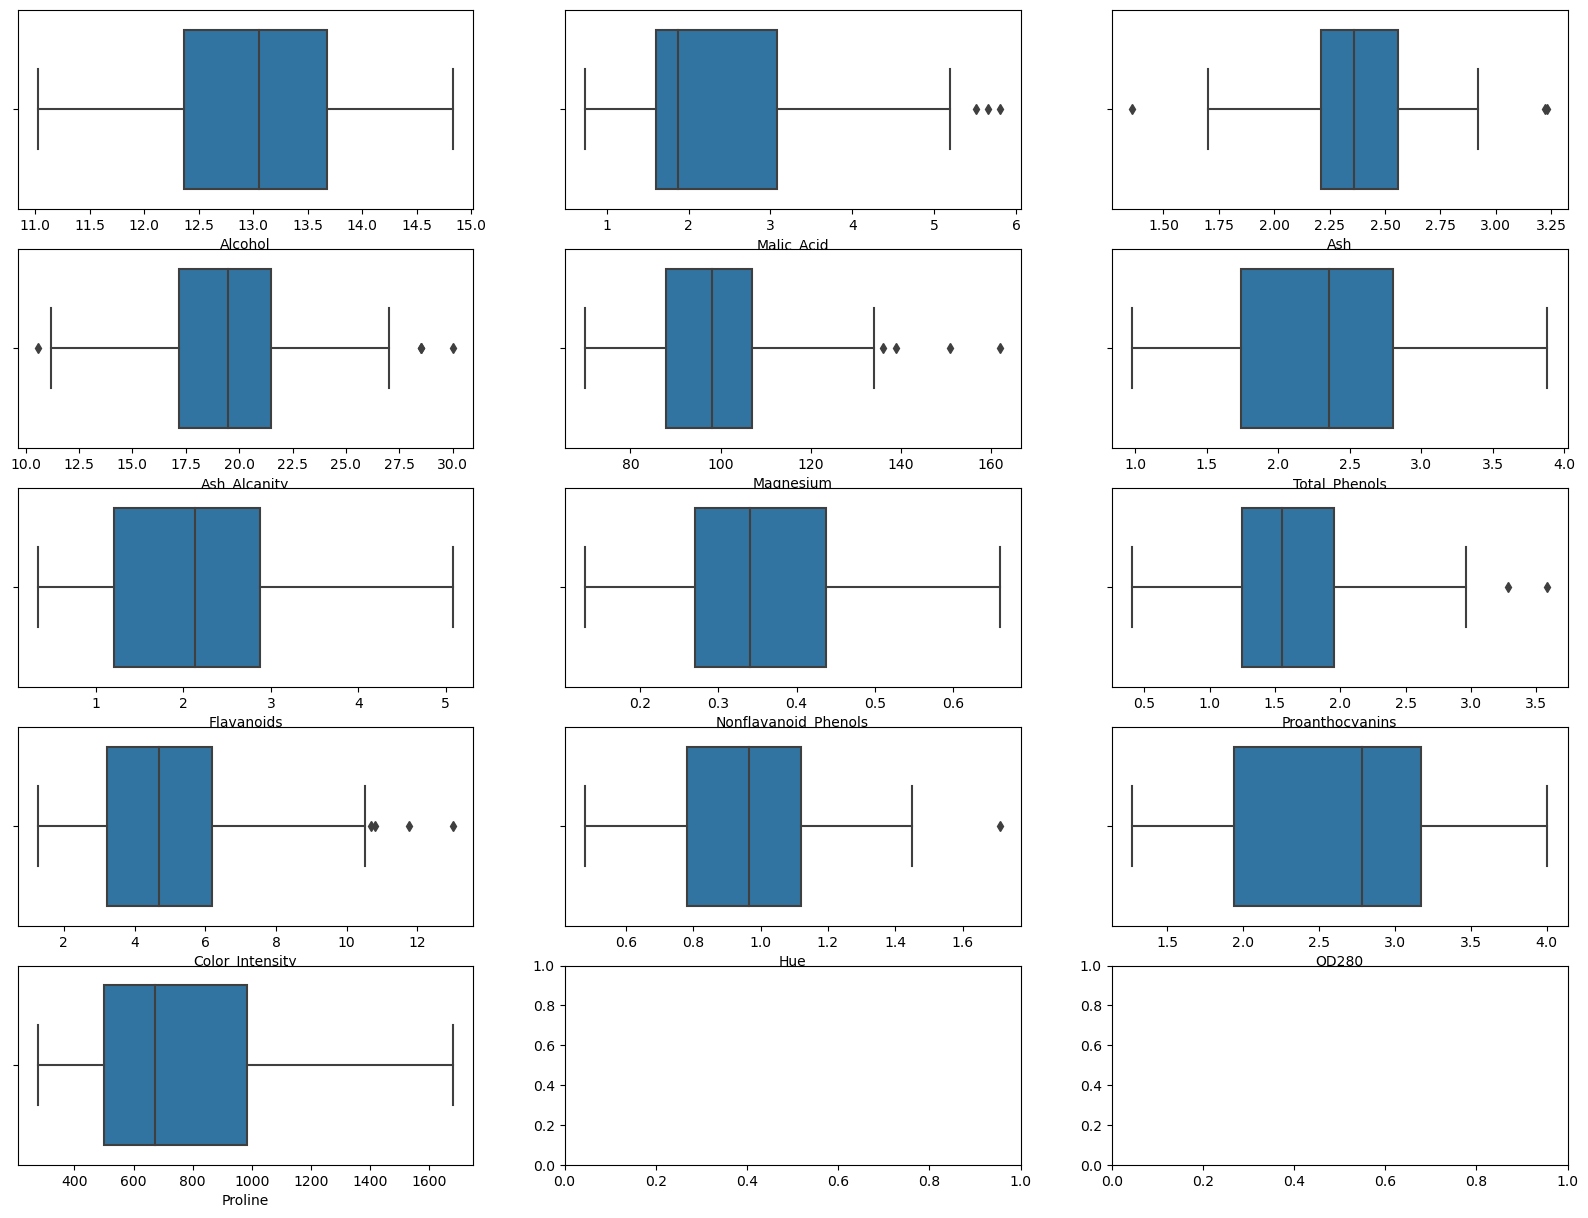

In [9]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(20,15))
axs = axs.ravel()

for i, c in enumerate(df):
    sns.boxplot(df, x=df[c], orient='h', ax=axs[i])

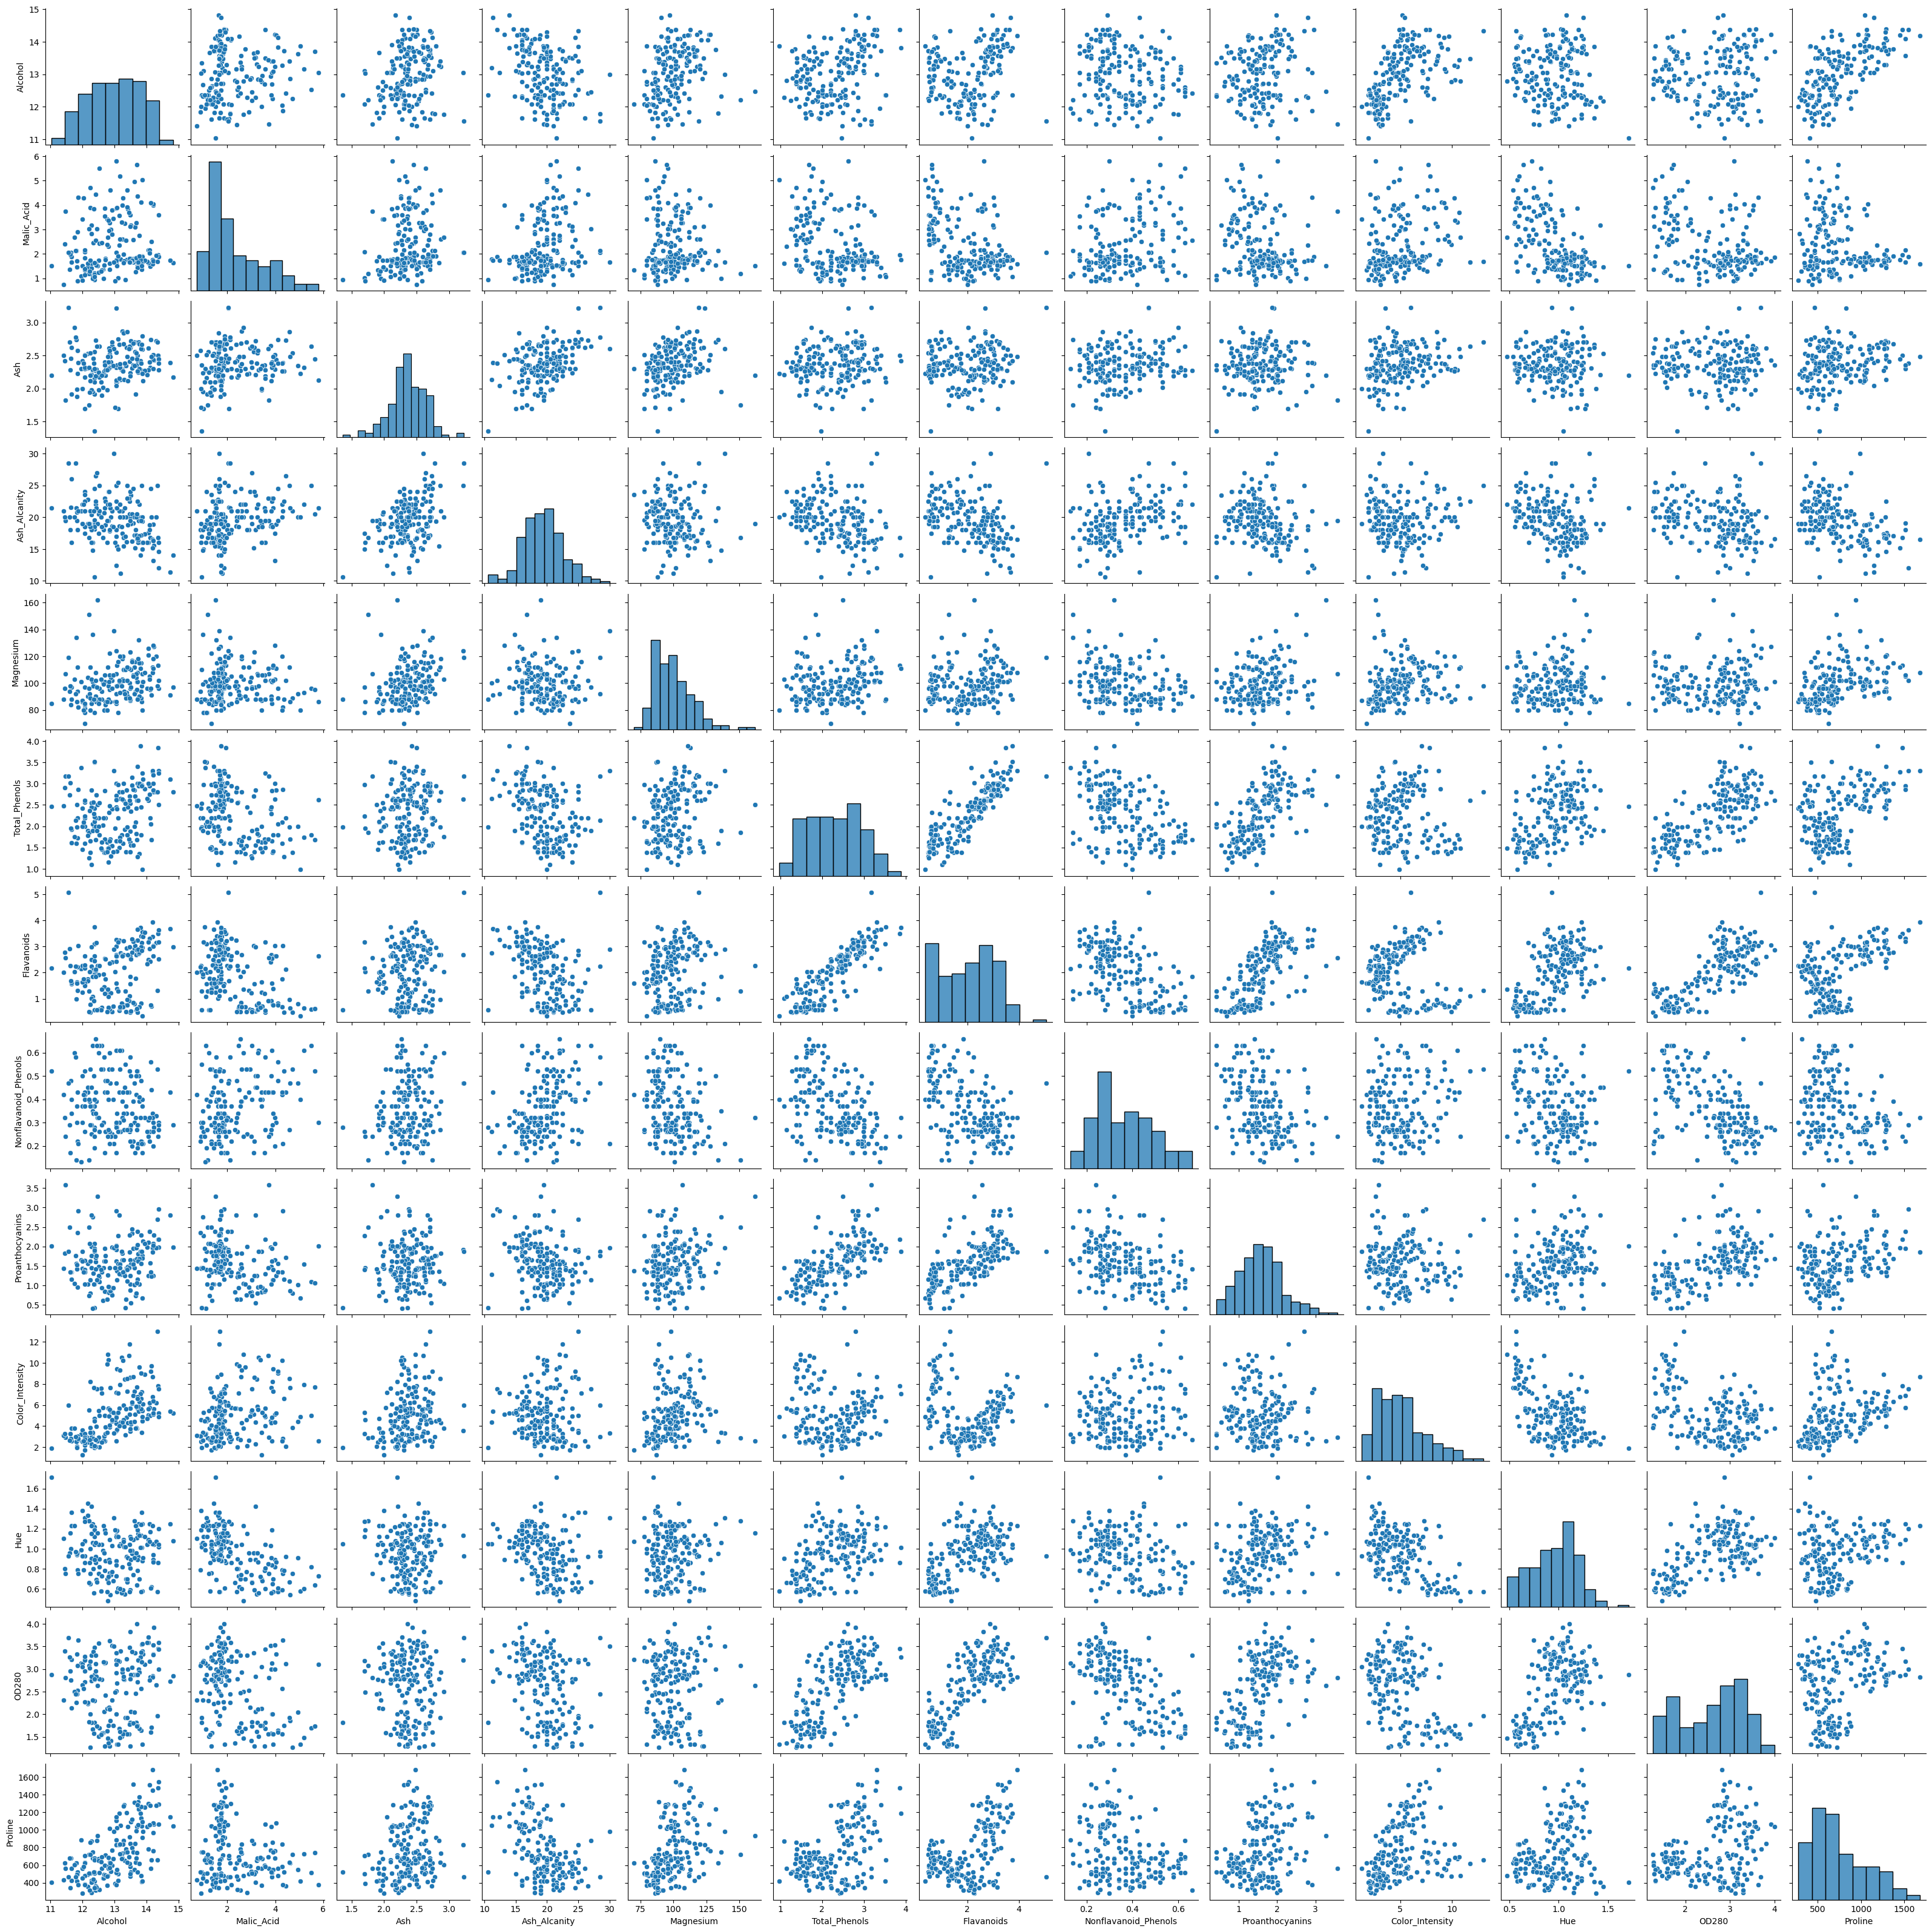

In [10]:
sns.pairplot(df)

---
# CONCLUSION from EDA:
## 


## Key findings from Heatmap:
Heatmap shows high positive correlation between the following features: 'Total_Phenols', 'Flavanoids' and 'OD280'.
At this point I decided to leave them in the dataset, and maybe to try to remove one or two of them later on, just for comparison with the first model. 

## Key findings from Histplots:  
Some of the columns have similar to normal distribution and some have skewed distribution. At this point I decided not to transform the features, because I think that skewness is not extreme.

## Key findings from Boxplots:
Box plots shows few outliers in some of the features. At this point I decided to leave them in the dataset.

## Key findings from Pairplot:
2D Pairwise relationships between variables in a dataset does not show visible clustering of the data. However, it's important to note that this analysis is limited to a two-dimensional representation and may not accurately represent the complexities of a multidimensional setting.

---

#
#

---
# 2.1 KMeans Clustering

### Determination of optimal K value with "The elbow method"

  File "C:\ProgramData\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 245, in _count_physical_cores
    raise ValueError(


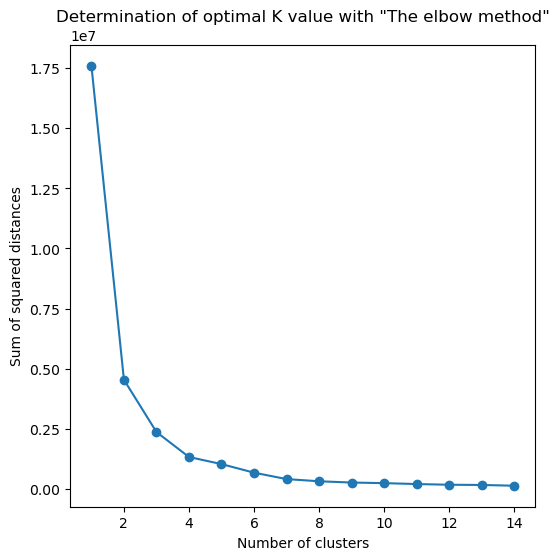

In [11]:
list_k = range(1, 15)
list_ssd = []
for k in list_k:
    km = KMeans(n_clusters=k, n_init='auto')
    km.fit(df)
    list_ssd.append(km.inertia_)

plt.figure(figsize=(6,6))
plt.plot(list_k, list_ssd, '-o')
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distances")
plt.title('Determination of optimal K value with "The elbow method"')
plt.show()

---
### Metric for evaluating the quality of clustering - Silhouette score 

In [12]:
def sil_eval(model, parameter_grid, df: np.array) -> tuple:
    best_score = -1
    best_grid = None
    n_labs = 0

    for params in tqdm.tqdm(parameter_grid):
        model.set_params(**params)
        model.fit(df)
        n_unique_labels = len(np.unique(model.labels_))
        if n_unique_labels == 1:
            continue
        current_score = silhouette_score(df, model.labels_)
        if current_score > best_score:
            best_score = current_score
            best_grid = params
            n_labs = n_unique_labels
    return best_score, best_grid, n_labs

---
### kMeans model

In [13]:
model_km = KMeans()

parameters = {
    'n_clusters': np.arange(1, 10, 1),
    'n_init': ['auto'], 
    'random_state': [RANDOM_STATE]
}
parameter_grid1 = ParameterGrid(parameters)
best_score, best_params, n_labs = sil_eval(model_km, parameter_grid1, df)

print('Best Score:      ', best_score)
print('Best Parameters: ', best_params)
print('Number of Labels:', n_labs)

100%|██████████| 9/9 [00:00<00:00, 11.71it/s]

Best Score:       0.6568536504294317
Best Parameters:  {'n_clusters': 2, 'n_init': 'auto', 'random_state': 42}
Number of Labels: 2


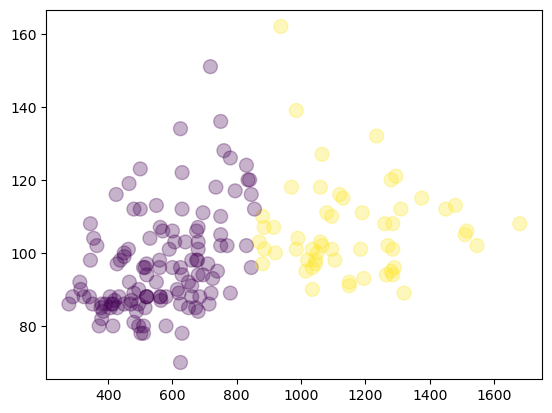

In [14]:
# Perform KMeans with best parametars

final_model_km = KMeans(n_clusters=best_params['n_clusters'], n_init=best_params['n_init'], random_state=RANDOM_STATE)
final_model_km.fit(df)
final_model_km_labels = final_model_km.labels_

# I decided to visualize these two features, because PCA suggested that these two were the most important features 
# in the dataset, especially 'Proline' feature. 
plt.scatter(df.loc[:, 'Proline'], df.loc[:, 'Magnesium'], c=final_model_km_labels, s=100, alpha=0.3)

---
# 2.2 Agglomerative Clustering

In [15]:
model_agg = AgglomerativeClustering()

parameters = {
    'linkage': ['ward', 'complete', 'average', 'single'],
    'n_clusters': np.arange(1, 10, 1), 
    'distance_threshold': [None]
}
parameter_grid2 = ParameterGrid(parameters)
best_score, best_params, n_labs = sil_eval(model_agg, parameter_grid2, df)

print('Best Score:      ', best_score)
print('Best Parameters: ', best_params)
print('Number of Labels:', n_labs)

100%|██████████| 36/36 [00:00<00:00, 127.31it/s]

Best Score:       0.6587292996216912
Best Parameters:  {'distance_threshold': None, 'linkage': 'ward', 'n_clusters': 2}
Number of Labels: 2


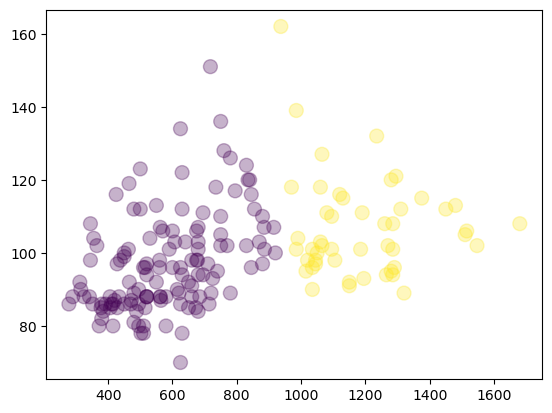

In [16]:
# Perform Agglomerative Clustering with best parametars

final_model_agg = AgglomerativeClustering(linkage=best_params['linkage'], n_clusters=best_params['n_clusters'],  distance_threshold=None)
final_model_agg.fit(df)
final_model_agg_labels = final_model_agg.labels_

# I decided to visualize these two features, because PCA suggested that these two were the most important features 
# in the dataset, especially 'Proline' feature. 
plt.scatter(df.loc[:, 'Proline'], df.loc[:, 'Magnesium'], c=final_model_agg_labels, s=100, alpha=0.3)

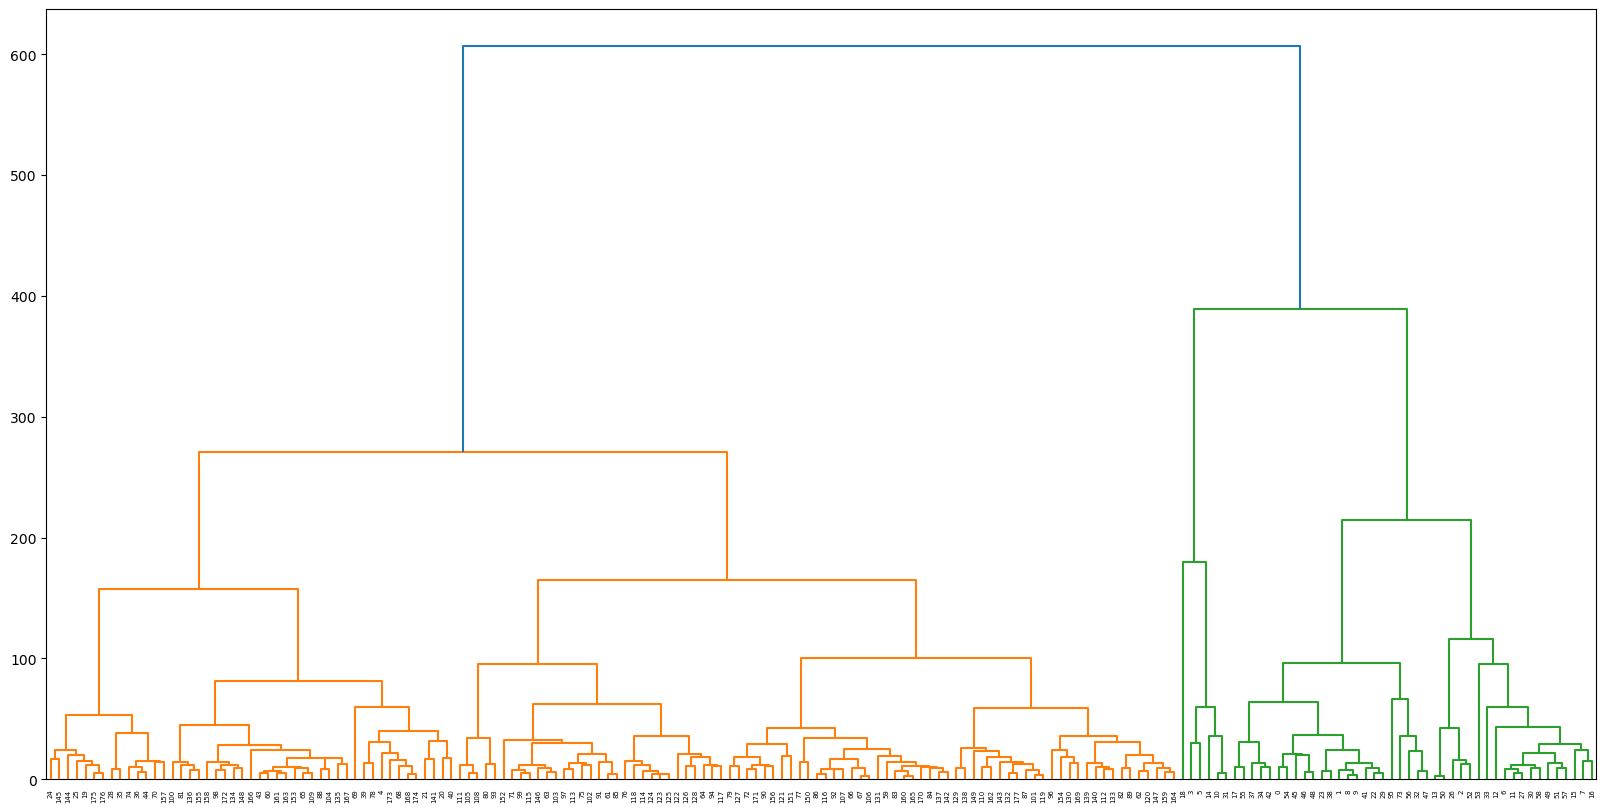

In [17]:
output = linkage(df, 'average')

fig = plt.figure(figsize=(20,10))
dendrogram(output)
plt.show()

## CONCLUSION:

Both **kMeans** and **Agglomerative Clustering** provided similar and satisfactory results, demonstrating effective clustering of the data. Agglomerative Clustering appears visually superior to kMeans, as the clusters are more easily distinguishable from one another.

**Silhouette score**   
As shown above with clustering methods: KMeans and Agglomerative Clustering, the optimal value of K (leading to the highest silhouette score) is:    
K = 2

**The elbow method**    
On the other hand this method shows different result, sum of square distances stops dropping rapidly around 4, showing that the optimal number of clusters is:    
K = 4

There's no definitive conclusion, which one of the two scores is more appropriate, and it may require some experimentation and validation to determine the most appropriate number of clusters for this specific dataset.
I decided to go with K = 2, and maybe try different clustering later on. 

---
# 3.2 PCA for Dimensionality Reduction

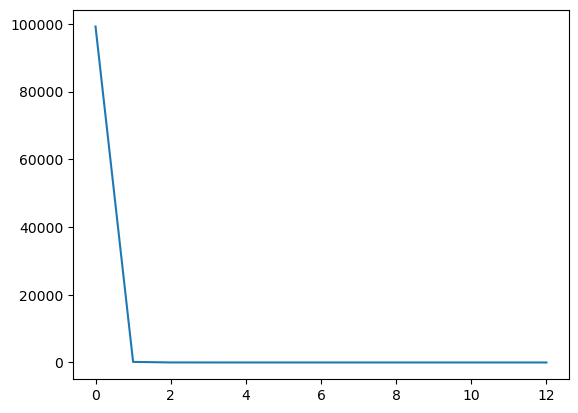

In [18]:
cov_df = np.cov(df.T)

eigen_values, eigen_vectors = np.linalg.eigh(cov_df)

idx = np.argsort(-eigen_values)

eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:, idx]

plt.plot(eigen_values)

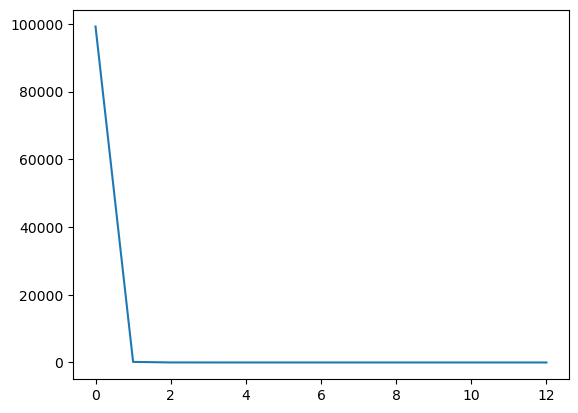

In [19]:
pca = PCA()
fitted_data = pca.fit(df)
variance = fitted_data.explained_variance_ 

plt.plot(variance)

In [20]:
pca.n_components = 2
transformed_data = pca.fit_transform(df)

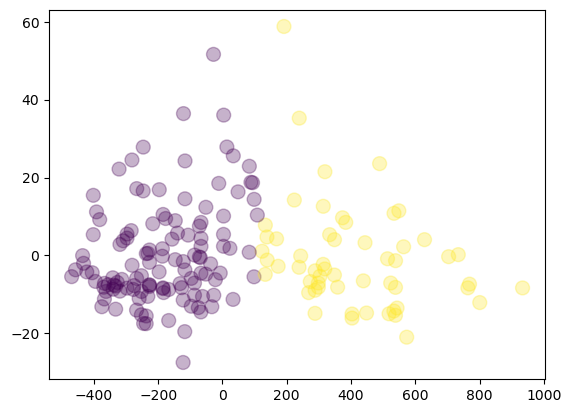

In [21]:
# Appling K-means clustering on the reduced-dimensional data

model_km_pca = KMeans(n_clusters=2, n_init='auto', random_state=RANDOM_STATE)
model_km_pca.fit(transformed_data)
model_km_pca_labels = model_km_pca.labels_

plt.scatter(transformed_data[:,0], transformed_data[:,1], c=model_km_pca_labels,  s=100, alpha=0.3)

Text(0.5, 1.0, 'Component-wise and Cumulative Explained Variance')

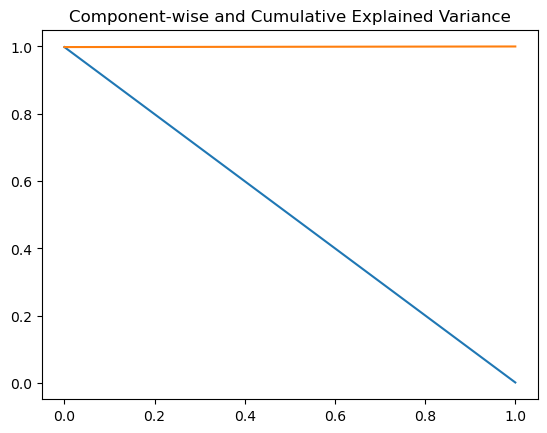

In [22]:
plt.plot(range(2), pca.explained_variance_ratio_)
plt.plot(range(2), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")

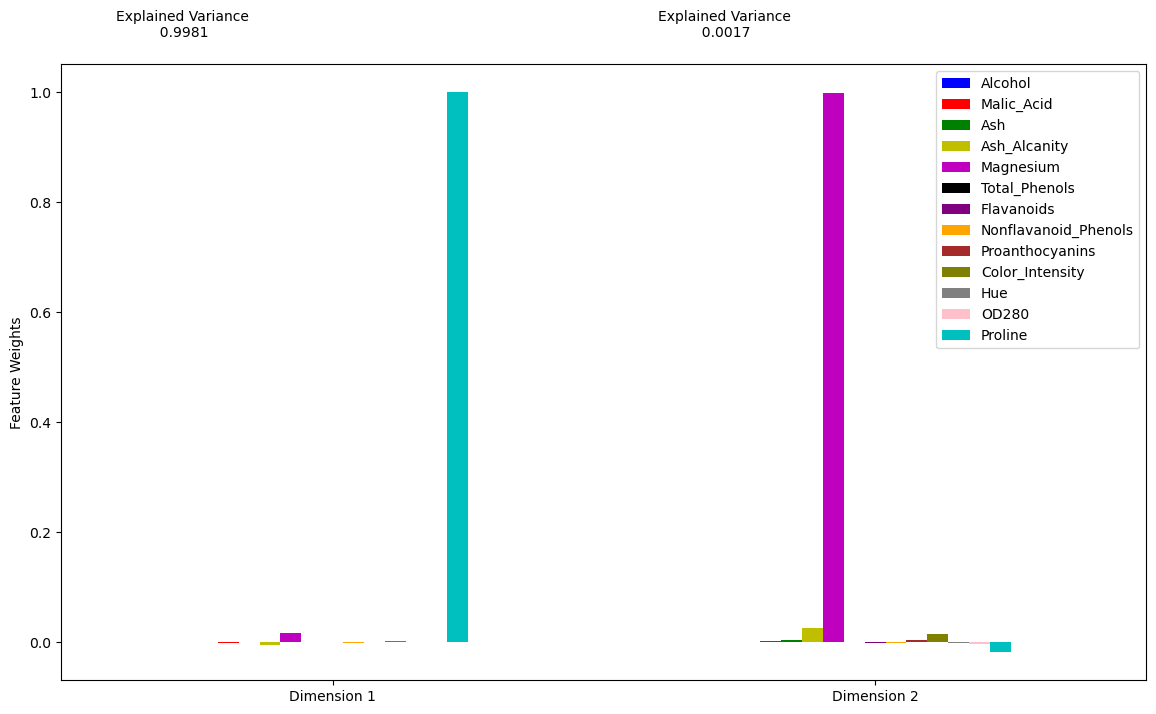

In [23]:
def pca_results(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1, len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns=list(good_data.keys()))
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns=['Explained Variance'])
    variance_ratios.index = dimensions

    # Define a list of distinct colors (with default coloring I received two of the features with same color, 
    # one of which was "Proline" feature and I wasn't sure which one is my dataset key component)
    colors = ['b', 'r', 'g', 'y', 'm', 'k', 'purple', 'orange', 'brown', 'olive', 'gray', 'pink', 'c']

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot the feature weights as a function of the components with different colors
    components.plot(ax=ax, kind='bar', color=colors[:len(components.columns)])
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)

    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis=1)

pca_results = pca_results(df, pca)

## CONCLUSION from PCA:

## Eigenvalues
The method for calculation of eigenvalue was computed manually and automatically. I found the eigenvalue plot strange, so I tried it both ways. The resulting plot was exactly the same and showed that there is ONLY ONE high importance feature in a dataset.
I decided to take first 2 eigen vectors and that will be the transformation matrix to decrease the dimensionality of our dataset. Then transform the original 13 dimensional data into 2 dimensions.


## Component-wise and Cumulative Explained Variance    

In the graph, the blue line represents component-wise explained variance while the orange line represents the cumulative explained variance. We are able to explain around 100% variance in the dataset using just two components.


## Inference    

First 2 Principal components:

1st PC:&nbsp; 99.81%   
2nd PC:&nbsp;&nbsp; 0.17%

**Total:&nbsp;&nbsp;&nbsp;&nbsp; 99.98%**

**First Dimension:** From the above plot it is noticed that the weight is largest and positive for 'Proline', meaning that the dataset has only one high importance feature. In order to visualize the clusters in 2D, I decided to take second component, that has very low importance, but together both make impact of nearly 100%.

**Second Dimension**: From the above plot it is noticed that the weight is large and positive for 'Magnesium' but again the impact of this feature is only 0.17%.

#



---
# 3.2 t-SNE for dimensionality reduction and visualization

In [24]:
tsne_components = 2
model_tsne = TSNE(n_components = tsne_components, n_iter = 5000)
transformed_tsne = model_tsne.fit_transform(df)

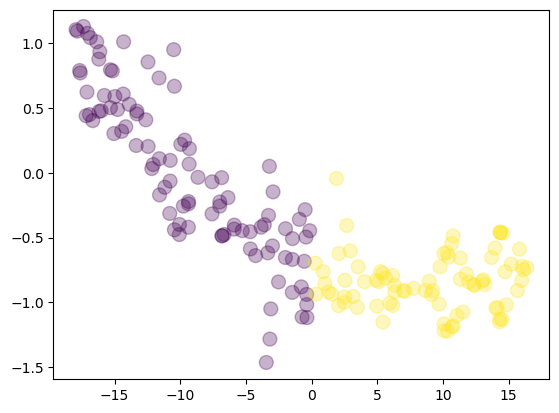

In [25]:
# Appling K-means clustering on the reduced-dimensional data

model_km_tsne = KMeans(n_clusters=2, n_init='auto', random_state=RANDOM_STATE)
model_km_tsne.fit(transformed_tsne)
model_km_tsne_labels = model_km_tsne.labels_

plt.scatter(transformed_tsne[:,0], transformed_tsne[:,1], c=model_km_tsne_labels,  s=100, alpha=0.3)

In [26]:
tsne_components = 3
model_tsne = TSNE(n_components = tsne_components, n_iter = 5000)
transformed_tsne = model_tsne.fit_transform(df)

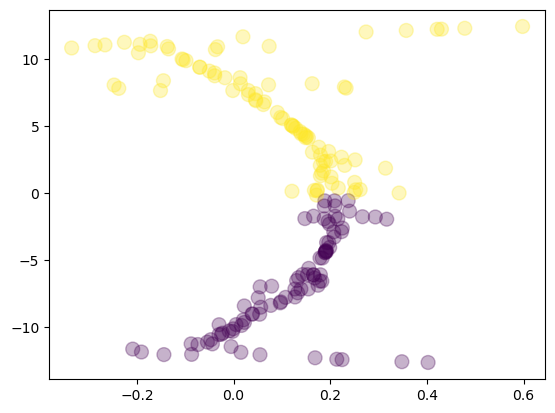

In [27]:
# Appling K-means clustering on the reduced-dimensional data

model_km_tsne = KMeans(n_clusters=2, n_init='auto', random_state=RANDOM_STATE)
model_km_tsne.fit(transformed_tsne)
model_km_tsne_labels = model_km_tsne.labels_

plt.scatter(transformed_tsne[:,2], transformed_tsne[:,0], c=model_km_tsne_labels,  s=100, alpha=0.3)

## CONCLUSION from tSNE:

We use this method generaly as a tool to visualize high-dimensional data to a lower-dimensional space: 2D or 3D. The method is different than PCA and ussualy is recommended to use it after dimensionality reduction with PCA. In this assignment, for demonstration only, was used on a whole dataset. I made one plot with 2 components, as suggested with PCA, and one with 3 components for demostration only. 
